# Plotting fire locations and MaxEnt fire probabilities

Authors: Jatan Buch (v1, 230328)

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
#from time import clock
from datetime import date, datetime, timedelta
from cftime import num2date, date2num, DatetimeGregorian
from tqdm import tqdm
from copy import deepcopy

#Import and write files
import csv
import netCDF4 # module that reads in .nc files (built on top of HDF5 format)
import pandas as pd
import geopandas as gpd
from geopandas.tools import sjoin
import xarray
import rioxarray

from shapely.geometry import Point, mapping
from shapely.geometry.polygon import Polygon
from pyproj import CRS, Transformer # for transforming projected coordinates to elliptical coordinates
import cartopy.crs as ccrs # for defining and transforming coordinate systems
import cartopy.feature as cfeature # to add features to a cartopy map
import cartopy.io.shapereader as shpreader

#Helper functions
from math import factorial
from scipy import stats
from scipy.special import gamma
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.exceptions import NotFittedError

#Plot modules
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from plot_params import params
import matplotlib.pylab as pylab
pylab.rcParams.update(params)
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

%matplotlib inline
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'

#Stats modules
from scipy import stats
from scipy.stats import norm, pareto, genpareto
import statsmodels.api as sm
from scipy import stats, interpolate
from scipy.optimize import minimize

# Data processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, SplineTransformer
from sklearn.model_selection import train_test_split
import joblib
from sklearn.pipeline import make_pipeline

#modules for Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
import shap

#modules for Neural Network
# import tensorflow as tf
# import tensorflow_probability as tfp
# tfd= tfp.distributions
# from tensorflow.keras.layers import Input, Dense, Activation, Concatenate
# from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
def coord_transform(coord_a, coord_b, input_crs= 'WGS84', output_crs= 'EPSG:5070'):
    #function to convert coordinates between different reference systems with a little help from pyproj.Transformer
    #custom crs i/o with https://gis.stackexchange.com/questions/427786/pyproj-and-a-custom-crs
    
    crs_4326 = CRS("WGS84")
    crs_proj = CRS(output_crs)
    
    if input_crs != 'WGS84':
        transformer= Transformer.from_crs(crs_proj, crs_4326) #ESRI:54008
    else:
        transformer= Transformer.from_crs(crs_4326, crs_proj)
        
    # we add another if-else loop to account for differences in input size: for different sizes, we first construct a meshgrid,
    # before transforming coordinates. Thus, the output types will differ depending on the input.
    if len(coord_a) == len(coord_b):
        return transformer.transform(coord_a, coord_b) 
    else:
        coord_grid_a, coord_grid_b= np.meshgrid(coord_a, coord_b)
        return transformer.transform(coord_grid_a, coord_grid_b)

In [4]:
wildfire_df= pd.read_csv("../data/firelist/west_US_fires_1984_2020.txt", 
                         usecols= (0, 1, 9, 18, 19, 20, 21, 22, 23, 24), delimiter= ',')
reg_obs_freq= xarray.open_dataarray('../sav_files/obs_freq_prob.nc')
longterm_prob_df= pd.read_hdf('../sav_files/clim_fire_mon_prob_dfs/pred_fire_masked_prob_all_mons.h5')

lat_long_fire_grid= coord_transform(reg_obs_freq['X'][:].data, reg_obs_freq['Y'][:].data, input_crs= 'EPSG:5070')

In [5]:
pred_freq_xarr= xarray.DataArray(data= longterm_prob_df[0].to_numpy().reshape(208, 155),
                dims=["Y", "X"],
                coords=dict(
                    X=(["X"], np.linspace(-2349250, -501250, 155)),
                    Y=(["Y"], np.linspace(3166500, 682500, 208)),),)

for i in tqdm(range(11)):
    tmp_freq_xarr= xarray.DataArray(data= longterm_prob_df[i+1].to_numpy().reshape(208, 155),
                dims=["Y", "X"],
                coords=dict(
                    X=(["X"], np.linspace(-2349250, -501250, 155)),
                    Y=(["Y"], np.linspace(3166500, 682500, 208)),),)
    pred_freq_xarr= xarray.concat([pred_freq_xarr, tmp_freq_xarr], dim= 'month')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 333.92it/s]


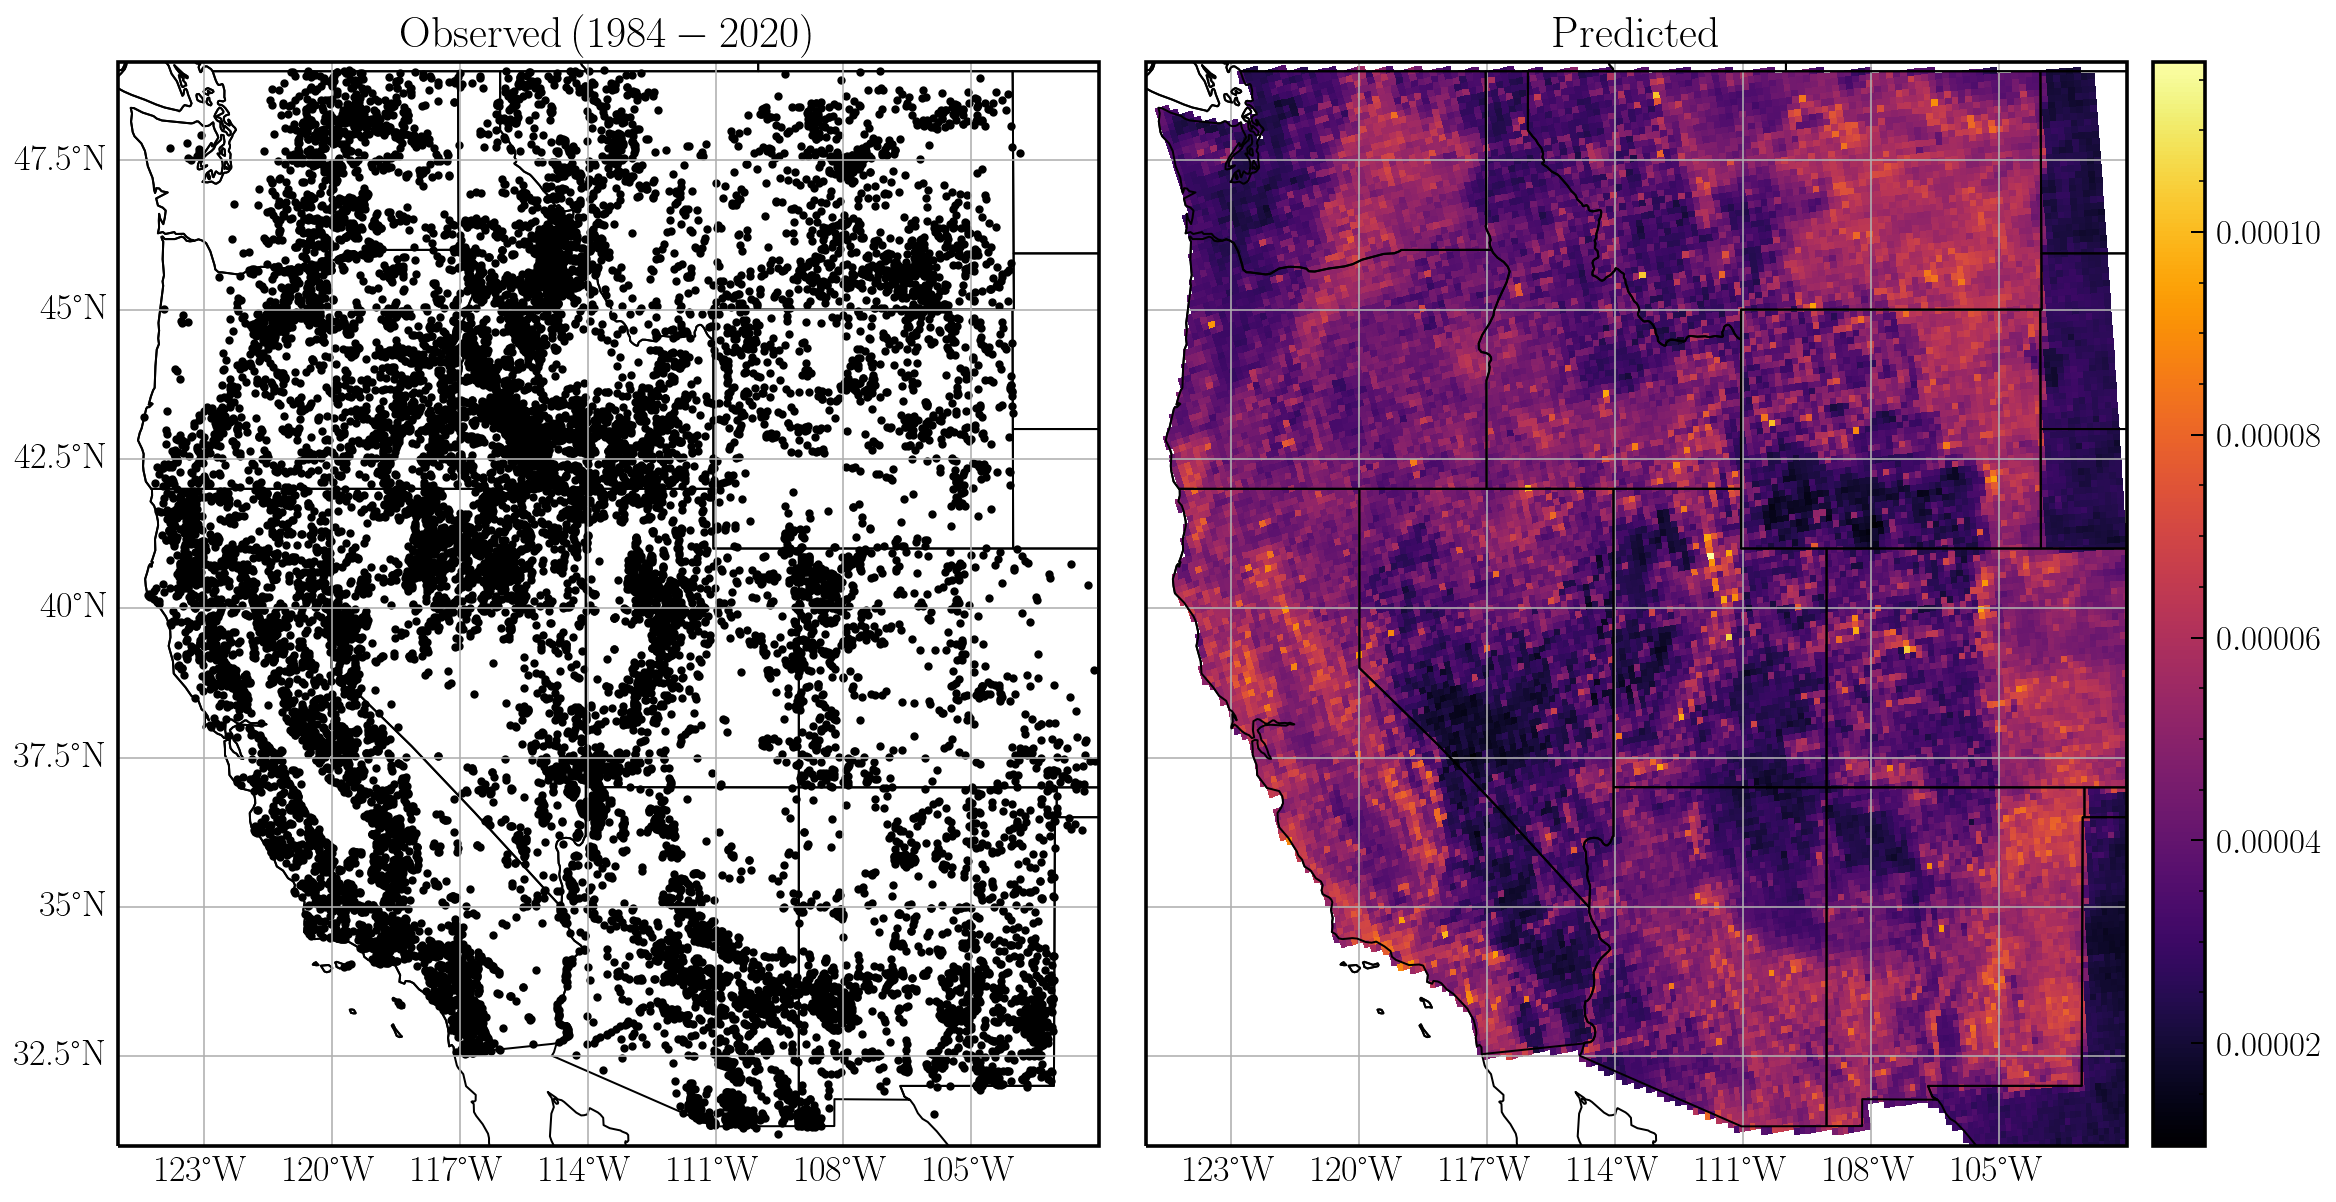

In [6]:
extent = [-125, -102, 31, 49] 
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])
#colors= np.random.rand(14)

fig= plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 4)

ax= fig.add_subplot(gs[0:2, 0:2], projection=ccrs.PlateCarree())
ax.set_extent(extent);
ax.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax.add_feature(cfeature.STATES, edgecolor='black');

ax.scatter(wildfire_df['final_lon'], wildfire_df['final_lat'], c= 'black', s= 10, transform=ccrs.PlateCarree())
#ax.tick_params(labeltop=False, top=False, labelright=False, right=True, which='both', labelsize= 30);

gl= ax.gridlines(draw_labels=True);
gl.xlabel_style = {'size': 18, 'color': 'black'}
gl.ylabel_style = {'size': 18, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl.top_labels = False
gl.right_labels = False
ax.set_aspect(1.4/1) 
ax.set_title(r'$\rm{Observed} \, (1984-2020)$', fontsize= 22);

fig.subplots_adjust(wspace= 0.1)

ax0= fig.add_subplot(gs[0:2, 2:], projection=ccrs.PlateCarree())
ax0.set_extent(extent);
ax0.add_feature(cfeature.LAND, edgecolor='black', facecolor= 'white');
ax0.add_feature(cfeature.STATES, edgecolor='black', zorder= 10);

gl0= ax0.gridlines(draw_labels=True);
gl0.xlabel_style = {'size': 18, 'color': 'black'}
gl0.ylabel_style = {'size': 18, 'color': 'black'}
#gl.xlocator = mticker.FixedLocator([-116, -117, -118, -119, -120, -121, -122, -123, -124])
#gl.ylocator = mticker.FixedLocator([34, 36, 38, 40, 42])
gl0.top_labels = False
gl0.left_labels = False
gl0.right_labels = False
ax0.set_aspect(1.4/1) 

CS= ax0.pcolormesh(lat_long_fire_grid[1], lat_long_fire_grid[0], pred_freq_xarr.sum(axis= 0, skipna= False)/np.sum(pred_freq_xarr.sum(axis= 0, skipna= False)), cmap=plt.cm.inferno) # pred_freq_xarr/np.max(pred_freq_xarr).values
cax= fig.add_axes([ax0.get_position().x1+0.01,ax.get_position().y0,0.02,ax0.get_position().height])
cbar= fig.colorbar(CS, cax= cax, shrink= 0.7)
ax0.set_title(r'$\rm{Predicted}$', fontsize= 22);
#plt.savefig('../paper_plots/summary_plot.png', bbox_inches='tight', dpi= 200);